# Dilated CNN
Notebook for final predictions for February 2021

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import os

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import tensorflow as tf
from tqdm import tqdm


### Reading in Preprocessed datasets
Concatting the the preprocessed datasets. I chose a work around by deleting the date column while concatting the individual dataframes AND then at the end set the index to the sample date index.

In [3]:
# Work around for concatting muiltiple region datasets
# Read the one of the dataframe sfor the Date columns
df = pd.read_csv('data_regions/NSW_iso.csv')
merge_index = pd.to_datetime(df['Date'])

del df

In [4]:
# For loop for the 7 region datasets
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']

# Instantiate a pandas dataframe with the length of the date column
merge_df = pd.DataFrame(index = range(len(merge_index)))
for each in regions:
    df = pd.read_csv('data_regions/{}_iso.csv'.format(each))
    df.drop(columns = ['Date'], inplace=True)
    # for each region concatenate
    merge_df = pd.concat([merge_df, df], axis = 1)
# Finally reset the index with Datetime
merge_df.index = merge_index
print('Before Clipping: {}'.format(merge_df.shape))
print('\n')
# Dropping values observations from 2021-01-19 to 2021-01-22
# There seems to be more missing values and I will interpolate the missing values
merge_df = merge_df['2005-01-01':'2021-01-18'].copy()

# There are 3 missing values within the temperature statistics (01-10-2021, 01-11-21, 01-17-21)
# Interpolate the missing values
merge_df.interpolate(inplace=True)
print('After Clipping: {}'.format(merge_df.shape))

Before Clipping: (5866, 63)


After Clipping: (5862, 63)


### Feature Engineering
Transform the estimated fire area to log scale and exponentiate after predicting in log scale form. <br>

Surface Area:
- Assume the fire areas are conglomerated into one pixel and the surface area would be <br>
4 * square root of the Area

- Assume the fire area pixels are separated(non touching) and the areas of each pixel are the same.<br>
The surface area would be the count of the pixels * square root of (area / count)

In [5]:
fire_regions = ['Estimated_fire_area_{}'.format(i) for i in regions]
count_regions = ['Count_{}'.format(i) for i in regions]
sqrt_fire_regions = ['sqrt_{}'.format(i) for i in fire_regions]
sqrt_count_regions = ['sqrt_Count_{}'.format(i) for i in regions]

for i,x in zip(fire_regions, count_regions):
    merge_df[i] = np.log1p(merge_df[i])
    merge_df[x] = np.log1p(merge_df[i])
    
# merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)


for i,x in zip(fire_regions, count_regions):
    merge_df['sqrt_{}'.format(i)] = np.sqrt(merge_df[i])
    merge_df['sqrt_{}'.format(x)] = np.sqrt(merge_df[i]/merge_df[x]) * merge_df[x]
    
# sqrt_count_regions has NaN when dividing by 0
merge_df.fillna(0, inplace=True)

In [6]:
# reassigning the columns so the 7 estimated fire areas are the first 7 columns of the dataframe
merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)
merge_df.head()

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.000000,1.782551,3.684660,0.0,0.0,0.000000,3.621203,0.000000,0.044274,36.355567,...,1.919547,2.385413,0.0,0.0,0.0,0.0,0.000000,0.000000,1.902946,2.354318
2005-01-02,0.000000,0.841567,4.181505,0.0,0.0,1.335001,5.004661,0.000000,0.173879,38.699607,...,2.044873,2.622780,0.0,0.0,0.0,0.0,1.155422,1.064001,2.237110,2.995168
2005-01-03,0.000000,4.496917,3.879223,0.0,0.0,0.693147,4.121185,0.000000,3.011912,49.365152,...,1.969574,2.479620,0.0,0.0,0.0,0.0,0.832555,0.604155,2.030070,2.594511
2005-01-04,2.270062,0.000000,3.437208,0.0,0.0,0.000000,4.470200,1.184809,2.808620,57.095628,...,1.853971,2.263079,0.0,0.0,0.0,0.0,0.000000,0.000000,2.114285,2.756135
2005-01-05,2.868538,0.000000,1.609438,0.0,0.0,0.000000,3.477508,1.352877,0.157935,47.170735,...,1.268636,1.242444,0.0,0.0,0.0,0.0,0.000000,0.000000,1.864808,2.283203


### Train test split

In [7]:
# separating the train test split
# the values of the test set will be validated from the input of the last 120 days of the train set
# It's important to note that after windowing of the training set, the last input days will be 41 days before 2020-12-01(2020-06-23:2020-10-21)
# and will be validated by the last 41 days before 2020-12-01(2020-10-22:2020-12-01)
# Please look below at windowing for more explanation
train = merge_df[:'2020-12-01']
test = merge_df['2020-12-01':]

print('Training Shape: {}'.format(train.shape))
print('\n')
print('Testing Shape: {}'.format(test.shape))

Training Shape: (5814, 77)


Testing Shape: (49, 77)


### Preprocessing
I chose MinMaxScaler because I want to retain the original distribution shape while scaling the features to a range value of 0 and 1. <br>
The dataset needs to get windowed, essentially chopping the (5814, 77) training dataframe to 2 matrices X and y:<br>
X: <br>
(number of sequences, input steps, input features) <br>
y: <br>
(number of sequences, output steps, output features) <br>


In [8]:
# MinMax Scaled
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

# Sequence split used from machine learning mastery
def split_sequence(sequences, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(0, len(sequences), 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, :7]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)


n_steps_in, n_steps_out = 120, 41
X, y = split_sequence(scaled_train, n_steps_in, n_steps_out)
print('X shape: {}'.format(X.shape))
print('\n')
print('y shape: {}'.format(y.shape))


X shape: (5654, 120, 77)


y shape: (5654, 41, 7)


In [9]:
# The output should predict the next 41 days for the 7 regions
# In order to fit into the model I will essentiall flatten the 41 output steps and 7 regions to a long array
# From (5654 sequences, 41 output steps, 7 regions) to (5654 sequences, 287 outputs)
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
n_features = X.shape[2]
print('y shape after flatten: {}'.format(y.shape))

y shape after flatten: (5654, 287)


### DCNN Model
I fit the model once with an increasing learning rate from 1e-6 to 1e-1 to find my a stable learning rate for the final model. <br>
After I can visually locate the learnign rate, I refit the model over 1500 epochs.

In [12]:
# DCNN architecture taken from Joseph Eddy
# https://github.com/JEddy92/TimeSeries_Seq2Seq
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
history_seq = tf.keras.layers.Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = tf.keras.layers.Conv1D(16, 1, activation='relu')(x) 
    
    # filter convolution
    x_f = tf.keras.layers.Conv1D(filters=n_filters,
                                kernel_size=filter_width, 
                               activation = 'tanh',
                                padding='causal',
                                dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = tf.keras.layers.Conv1D(filters=n_filters,
                                 kernel_size=filter_width, 
                                 activation = 'sigmoid',
                                 padding='causal',
                                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = tf.keras.layers.Multiply()([x_f, x_g])
    
    # postprocessing - equivalent to time-distributed dense
    z = tf.keras.layers.Conv1D(16, 1, activation='relu')(z)

    
    # residual connection
    x = tf.keras.layers.Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = tf.keras.layers.Add()(skips)

# final time-distributed dense layers 
out = tf.keras.layers.Conv1D(128, 1, activation = 'relu')(out)
out = tf.keras.layers.Dropout(.2)(out)
out = tf.keras.layers.Conv1D(1, 1,)(out)
out = tf.keras.layers.Flatten()(out)
pred_seq_train = tf.keras.layers.Dense(n_output, activation = 'relu')(out)

model = tf.keras.Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr = 1e-6)

model.compile(optimizer, loss= tf.keras.losses.Poisson(), metrics = ['mae'])

In [13]:
history = model.fit(X, y, epochs = 100, callbacks = [lr_schedule], validation_split = 0.2)

Epoch 1/100
142/142 [==============================] - 14s 97ms/step - loss: 2.5325 - mae: 0.2612 - val_loss: 2.6717 - val_mae: 0.2818
Epoch 2/100
142/142 [==============================] - 11s 78ms/step - loss: 2.5211 - mae: 0.2609 - val_loss: 2.6527 - val_mae: 0.2813
Epoch 3/100
142/142 [==============================] - 12s 82ms/step - loss: 2.5071 - mae: 0.2605 - val_loss: 2.6346 - val_mae: 0.2809
Epoch 4/100
142/142 [==============================] - 12s 86ms/step - loss: 2.4933 - mae: 0.2602 - val_loss: 2.6177 - val_mae: 0.2804
Epoch 5/100
142/142 [==============================] - 12s 83ms/step - loss: 2.4757 - mae: 0.2598 - val_loss: 2.5991 - val_mae: 0.2799
Epoch 6/100
142/142 [==============================] - 12s 83ms/step - loss: 2.4630 - mae: 0.2593 - val_loss: 2.5802 - val_mae: 0.2793
Epoch 7/100
142/142 [==============================] - 12s 81ms/step - loss: 2.4490 - mae: 0.2589 - val_loss: 2.5584 - val_mae: 0.2784
Epoch 8/100
142/142 [==============================] - 

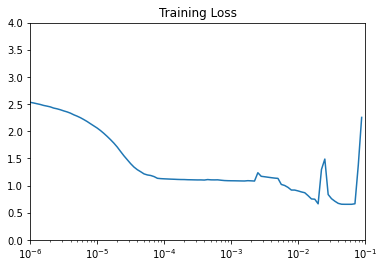

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 4])
plt.title('Training Loss');

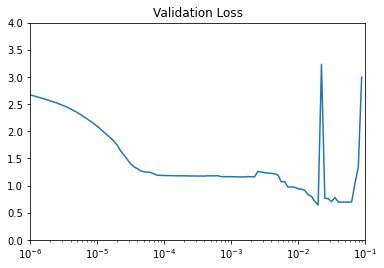

In [15]:
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e-1, 0, 4])
plt.title('Validation Loss');

In [16]:
# A learning rate between 1e-5 and 1e-4 seemed appropriate as the loss began fluctuating between 1e-4 and 1e-3
LEARNING_RATE = 1e-4

n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
history_seq = tf.keras.layers.Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = tf.keras.layers.Conv1D(16, 1, activation='relu')(x) 
    
    # filter convolution
    x_f = tf.keras.layers.Conv1D(filters=n_filters,
                                kernel_size=filter_width, 
                               activation = 'tanh',
                                padding='causal',
                                dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = tf.keras.layers.Conv1D(filters=n_filters,
                                 kernel_size=filter_width, 
                                 activation = 'sigmoid',
                                 padding='causal',
                                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    # works better than activations.swish - x * sigmoid(x)
    z = tf.keras.layers.Multiply()([x_f, x_g])
    
    # postprocessing - equivalent to time-distributed dense
    z = tf.keras.layers.Conv1D(16, 1, activation='relu')(z)

    
    # residual connection
    x = tf.keras.layers.Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = tf.keras.layers.Add()(skips)

# final time-distributed dense layers 
out = tf.keras.layers.Conv1D(128, 1, activation = 'relu')(out)
out = tf.keras.layers.Dropout(.2)(out)
out = tf.keras.layers.Conv1D(1, 1,)(out)
out = tf.keras.layers.Flatten()(out)
pred_seq_train = tf.keras.layers.Dense(n_output, activation = 'relu')(out)

model = tf.keras.Model(history_seq, pred_seq_train)


optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE
                                    )

# tf.keras.losses.Poisson()
model.compile(optimizer, loss=tf.keras.losses.Poisson(), metrics = ['mae'])

In [17]:
history = model.fit(X, y, epochs = 500)

Epoch 1/500
177/177 [==============================] - 14s 80ms/step - loss: 1.8696 - mae: 0.2483
Epoch 2/500
177/177 [==============================] - 13s 76ms/step - loss: 1.1586 - mae: 0.2065
Epoch 3/500
177/177 [==============================] - 13s 75ms/step - loss: 1.0835 - mae: 0.1922
Epoch 4/500
177/177 [==============================] - 14s 80ms/step - loss: 1.0723 - mae: 0.1862
Epoch 5/500
177/177 [==============================] - 13s 75ms/step - loss: 1.0671 - mae: 0.1837
Epoch 6/500
177/177 [==============================] - 13s 74ms/step - loss: 1.0638 - mae: 0.1809
Epoch 7/500
177/177 [==============================] - 13s 74ms/step - loss: 1.0553 - mae: 0.1795
Epoch 8/500
177/177 [==============================] - 13s 75ms/step - loss: 1.0376 - mae: 0.1771
Epoch 9/500
177/177 [==============================] - 15s 84ms/step - loss: 1.0356 - mae: 0.1754
Epoch 10/500
177/177 [==============================] - 14s 82ms/step - loss: 1.0341 - mae: 0.1736
Epoch 11/500
177/17

In [20]:
# model.save_weights('DCNN_011820')

In [21]:
### Validate on the test-set

In [22]:
x_input = np.array(train.iloc[-120:].values)
x_input = scaler.transform(x_input)

x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 287)

In [23]:
yhat_df = pd.DataFrame(yhat.reshape(41,7), index = test[:41].index, columns = fire_regions)

# create dummy variables to inverse transform
for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0
    
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

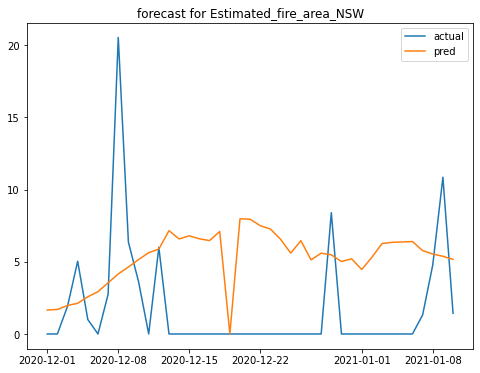

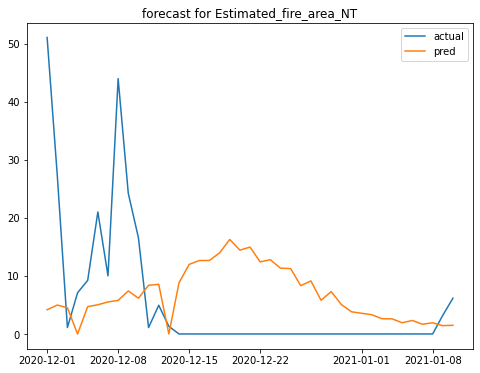

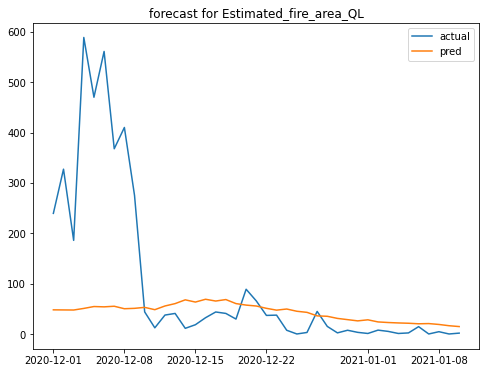

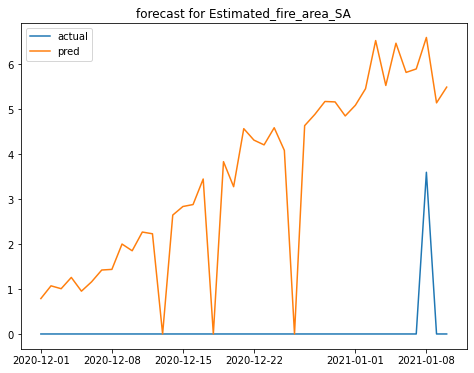

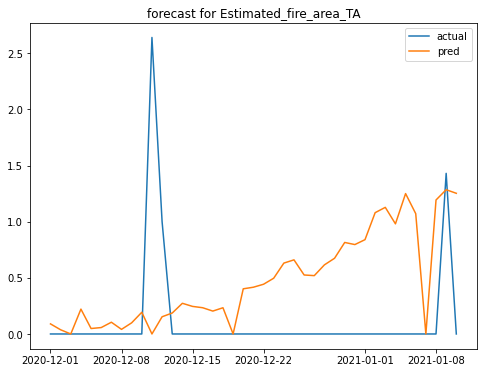

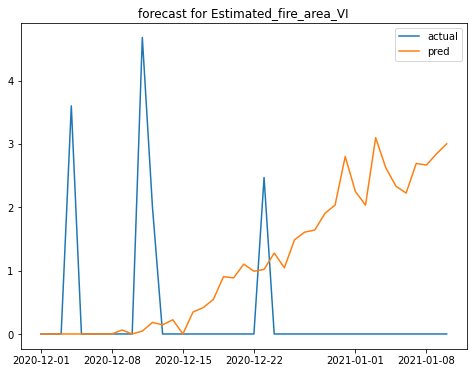

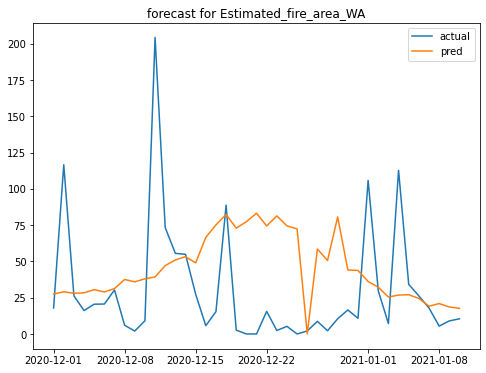

In [29]:
for i in fire_regions:
    plt.figure(figsize=(8,6))
    plt.plot(np.exp(test[:41][i]) - 1, label = 'actual')
    plt.plot(np.exp(yhat_df[i]) - 1, label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

In [46]:
from sklearn.metrics import mean_absolute_error
pred_flat = np.exp(yhat_df[fire_regions].values.flatten()) - 1
test_flat = np.exp(test[fire_regions].iloc[:41, :].values.flatten()) - 1
mean_absolute_error(test_flat, pred_flat)

21.19120657768171

In [47]:
# submission
x_input = np.array(merge_df.iloc[-120:].values)
x_input = scaler.transform(x_input)

x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 287)

In [51]:
yhat_df = pd.DataFrame(yhat.reshape(41,7), index = pd.date_range(start = '2021-01-19', end = '2021-02-28'), columns = fire_regions)


for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0
    
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

yhat_df[fire_regions]

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
2021-01-19,1.675920,2.717544,3.858922,0.736766,0.311783,0.520556,3.578114
2021-01-20,1.621828,2.835849,3.766555,0.806499,0.336613,0.418165,3.575913
2021-01-21,1.602934,2.857142,3.735388,0.733955,0.000000,0.453154,3.587844
2021-01-22,1.560671,0.000000,3.727862,0.793126,0.330955,0.408993,3.591256
2021-01-23,1.457597,2.915258,3.807053,0.738812,0.158660,0.414315,3.655931
2021-01-24,1.393428,2.948738,3.780088,0.734035,0.241448,0.251844,3.697815
2021-01-25,1.380958,2.895890,3.775150,0.762126,0.357364,0.419459,3.661853
2021-01-26,1.340768,2.850627,3.718735,0.782260,0.253346,0.383115,3.791146
2021-01-27,1.242800,2.935839,3.634558,0.877858,0.349331,0.356521,3.774214
2021-01-28,1.420911,2.817605,3.595155,0.860476,0.345404,0.433753,3.789525


In [52]:
submission = yhat_df['2021-02-01':'2021-02-28'][fire_regions]

In [53]:
submission_df = pd.melt(submission.reset_index().rename(columns={'index':'Date'}), id_vars = 'Date')

In [54]:
submission_df.rename(columns = {'variable': 'Region', 'value': 'Estimated_fire_area'}, inplace=True)
submission_df = pd.concat([submission_df[['Region']], submission_df[['Date']], submission_df['Estimated_fire_area']], axis = 1)

In [55]:
for i,x in zip(fire_regions, regions):
    submission_df['Region'].replace(to_replace = i, value = x, inplace=True)

In [56]:
submission_df['Date'] = submission_df['Date'].dt.strftime('%b-%d')

In [57]:
submission_df['Estimated_fire_area'] = np.exp(submission_df['Estimated_fire_area']) - 1
submission_df

,Region,Date,Estimated_fire_area
0,NSW,Feb-01,3.712188
1,NSW,Feb-02,4.375633
2,NSW,Feb-03,3.909223
3,NSW,Feb-04,3.919727
4,NSW,Feb-05,3.279012
...,...,...,...
191,WA,Feb-24,8.729274
192,WA,Feb-25,7.511663
193,WA,Feb-26,9.147712
194,WA,Feb-27,9.088242


In [58]:
# submission_df.to_csv('submissions/final_dcnn70.csv', index= False, header=True)

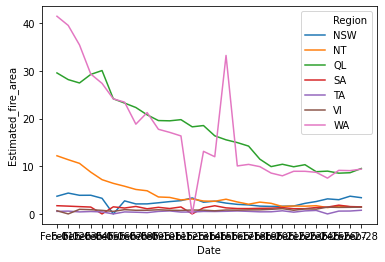

In [59]:
sns.lineplot(x = 'Date', y = 'Estimated_fire_area', hue = 'Region', data = submission_df)